In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import qcodes as qc
from personal.tools import fit_toolbox
qc.data.data_set.DataSet.default_io.base_location = 'E:\EWJN\data'
loc_provider = qc.data.location.FormatLocation(fmt='{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider
%matplotlib notebook

<IPython.core.display.Javascript object>

In [42]:
class T1_Measurement:
    def __init__(self, location, B0):
        self.B0 = B0
        self.location = location
        
        self.dataset = qc.load_data(self.location)
        
        if 'up_proportion_3_0_0' in self.dataset.arrays.keys():
            self.T1_label = 'up_proportion_3_0_0'
        else:
            self.T1_label = 'up_proportion'
        
        
        self.T1_wait_times, self.T1_data, self.T1_data_idx = self.sort_T1_data(self.dataset.T1_wait_time_set[0],
                                                                               self.dataset.arrays[self.T1_label])
        
        self.T1_data_mean, self.T1_data_std, self.T1_data_std_mean = self.analyse_T1_data()
        self.T1_fit_result = self.fit_T1(self.T1_wait_times, 
                                      self.T1_data_mean)

    def sort_T1_data(self, T1_wait_times_unsorted, T1_data_unsorted):
        T1_wait_times = np.sort(T1_wait_times_unsorted)
        T1_data_idx = np.argsort(T1_wait_times_unsorted)

        self.max_idx = np.sum([~np.isnan(np.sum(datarow)) for datarow in T1_data_unsorted])
        print('Number of successful sweeps: {}'.format(self.max_idx))
        T1_data = T1_data_unsorted[:self.max_idx, T1_data_idx]
        

        return T1_wait_times, T1_data, T1_data_idx

    def analyse_T1_data(self, T1_data=None):
        if T1_data is None:
            T1_data = self.T1_data
        T1_data_mean = np.mean(T1_data,axis=0)
        T1_data_std = np.std(T1_data,axis=0)
        T1_data_std_mean = T1_data_std/np.sqrt(len(T1_data))
        
        return T1_data_mean, T1_data_std, T1_data_std_mean

    def fit_T1(self, T1_wait_times=None, T1_data=None, weights='std'):
#         pass
        if T1_wait_times is None:
            T1_wait_times = self.T1_wait_times
        if T1_data is None:
            T1_data = self.T1_data
        if weights == 'std':
            std = np.std(T1_data,axis=0)/len(T1_data)
            weights = 1/std**2
        else:
            weights = [1]*len(T1_data)
            
        fit_model = fit_toolbox.ExponentialFit()
        fit_result = fit_model.perform_fit(T1_wait_times,
                                                T1_data, 
                                                weights=weights)
        self.T1 = fit_result.params['tau'].value
        self.T1_std = fit_result.params['tau'].stderr
        return fit_result
    
    def plot_T1(self, ax=None):
        if ax is None:
            fig = plt.figure()
            ax = fig.gca()

        # Plot individual datapoints
        for datarow in self.T1_data:
            ax.plot(self.T1_wait_times, datarow, 'ok', ms=3, alpha=0.2)


        # Plot mean datapoints with errorbars
        (_, caps, _) = ax.errorbar(self.T1_wait_times, self.T1_data_mean, yerr=self.T1_data_std_mean, 
                                   marker='o', linestyle='',ms=10)

        # Choose correct widths for errorbars
        for cap in caps:
            cap.set_markeredgewidth(3)

        # Plot fit curve
        plt.plot(self.T1_wait_times, self.T1_fit_result.best_fit, 'r-')

        ax.set_xscale("log")
        ax.set_xlim([0.9*self.T1_wait_times[0], 1.1*self.T1_wait_times[-1]])
        ax.set_ylim([0, 0.55])

        ax.set_xlabel('Wait time (ms)')
        ax.set_ylabel('Up population')
        
        return ax

In [46]:
T1_msmts = [T1_Measurement(B0=4,   location='2016-09-11/#014_T1_data_01-49-04'),
            T1_Measurement(B0=4.5, location='2016-09-10/#004_T1_data_00-08-32'),
            T1_Measurement(B0=5,   location='2016-09-10/#017_T1_data_13-39-35'),
            T1_Measurement(B0=3.5, location='2016-09-08/#003_T1_data_09-57-29'),
            T1_Measurement(B0=3,   location='2016-09-06/#013_T1_data_20-53-43'),
            T1_Measurement(B0=2.5,   location='2016-09-12/#010_T1_data_13-43-17')]



B0_fields = np.array([T1_msmt.B0 for T1_msmt in T1_msmts])
idx_sorted = np.argsort(B0_fields)
B0_fields = B0_fields[idx_sorted]
T1_values = np.array([T1_msmt.T1 for T1_msmt in T1_msmts])[idx_sorted]
T1_std = np.array([T1_msmt.T1_std for T1_msmt in T1_msmts])[idx_sorted]


Number of successful sweeps: 21
Number of successful sweeps: 30
Number of successful sweeps: 30
Number of successful sweeps: 13
Number of successful sweeps: 20
Number of successful sweeps: 2


In [86]:
import lmfit
def B5_polynomial(x, amplitude, offset):
    return amplitude*x**5 + offset

B5_model = lmfit.Model(B5_polynomial)
parameters=lmfit.Parameters()
parameters.add('amplitude', 1)
parameters.add('offset', 1)
B5_fit_result = B5_model.fit(T1_values, x=B0_fields, params=parameters)

In [89]:
B5_fit_result.best_fit

array([ 1195.79198448,  1147.82532297,  1054.68687531,   890.07799886,
         619.03696874,   196.70139457])

<IPython.core.display.Javascript object>


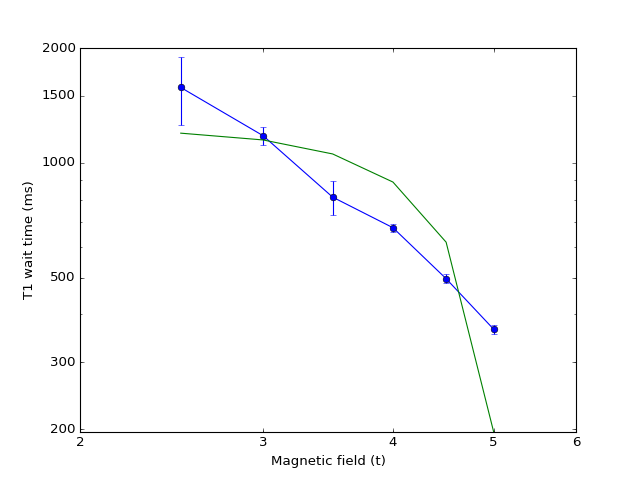

In [92]:
fig, ax = plt.subplots(1,1)
ax.errorbar(B0_fields, T1_values, yerr=T1_std, marker='o', linestyle='-')
ax.plot(B0_fields, B5_fit_result.best_fit, '-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2, 5.2)
ax.set_ylim(0, 2000)
ax.set_xticks([2,3,4,5,6])
ax.set_xticklabels([2,3,4,5,6])
yticks = [200,300,500,1000,1500, 2000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('Magnetic field (t)')
ax.set_ylabel('T1 wait time (ms)')